Эксперимент проходил с 2025-01-03 по 2025-01-09 включительно. Для эксперимента были задействованы 2 и 1 группы. 
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 
Задача — проанализировать данные А/B-теста. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse as ph
from scipy import stats


connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20250120',
'user':'student',
'password':'dpo_python_2020'
}


query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20250120.feed_actions
WHERE toDate(time) between '2025-01-03' and '2025-01-09'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(query, connection=connection)

Проверили предварительно группы АА-тестом за неделю до проведения теста, различия между выборками минимальны (t-test и гистограмма)

In [3]:
df.head(10)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750
5,2,131473,9,108,0.083333
6,2,23985,7,87,0.080460
7,2,24523,11,101,0.108911
8,2,32420,13,44,0.295455
9,2,24239,40,90,0.444444


In [4]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


In [5]:
df.groupby('exp_group').ctr.mean()

exp_group
1    0.216774
2    0.216102
Name: ctr, dtype: float64

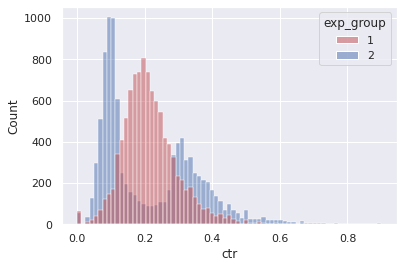

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Распределение в группе 2 бимодальное (двугорбое). Использовать t-test в этом случае некорректно.

In [7]:
#Сравниваем CTR в двух группах (тест Манна-Уитни)
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Результаты теста Манна-Уитни указывают на наличие статистически значимых различий между группами.

In [8]:
#Сравниваем CTR в двух группах (Пуассоновский бутстреп)
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

In [9]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

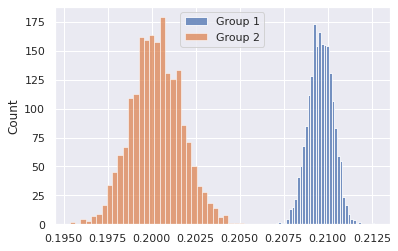

In [10]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, label='Group 1')
sns.histplot(ctr2, label='Group 2')

plt.legend()

<Axes: ylabel='Count'>

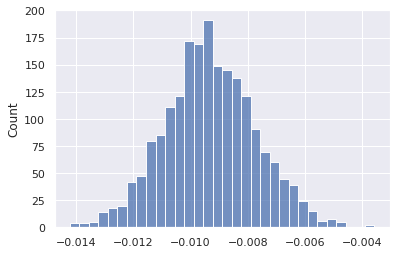

In [11]:
sns.histplot(ctr2 - ctr1)

Гистограмма разности не пересекает 0, значит CTR группы 1 больше группы 2. Это говорит нам о том, что новый алгоритм во 2-й группе мог привести к уменьшению CTR. 

t-тест и тест Манна-Уитни поверх бакетного преобразования

In [12]:
#Бакетное преобразование
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2025-01-03' and '2025-01-09'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = ph.read_clickhouse(q, connection=connection)

#тест Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [13]:
#t-тест 
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                df[df.exp_group == 2].bucket_ctr, 
                equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

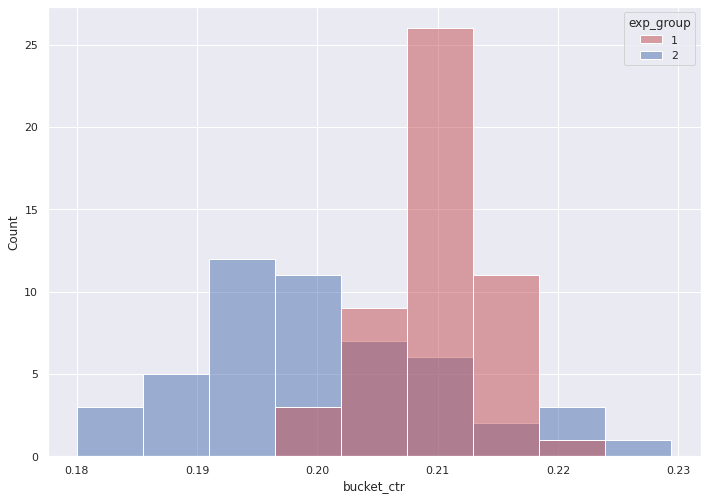

In [14]:
sns.set(rc={'figure.figsize':(11.7, 8.27)})
groups=sns.histplot(data=df, x= 'bucket_ctr', hue='exp_group', palette=['r', 'b'], alpha=0.5, kde=False)

Распределение похоже на нормальное. t-тест и тест Манна-Уитни поверх бакетного преобразования подтверждает статистически значимое различие между группой 1 и группой 2.

In [ ]:
С точки зрения общегруппового CTR алгоритм новый стал хуже, чем было. 

Пока не следует раскатывать новый алгоритм на всех новых пользователей, необходимо провести повторный тест.Так как нам, неизвестно точно, что привело к более низкому показателю CTR во второй группе.